## Probability and Naive Bayes

「你對此分類的準確度有多少信心」

一個運動員 54 吋高，95磅重，你也許會說她是跳體操的，但也不太敢肯定，因為有些馬拉松運動員也是類似的身高體重。如果使用的是基於概率的分類貝葉斯算法(Bayes)——那就可以給出分類結果的可能性了：這名運動員有80%的機率是籃球運動員；這位病人有40%的機率患有糖尿病；拉斯克魯塞斯24小時內有雨的概率是10%。

- 貝葉斯算法的優點即：
- 能夠給出分類結果的置信度；
- 它是一種主動學習算法 (eager learners)。NN is a Lazy Learners
- 實現簡單（只需計數即可） 
- 需要的訓練集較少，運算效率高 

貝葉斯方法的主要缺點是無法學習特徵之間的相互影響。比如我喜歡奶酪，也喜歡米飯，但 是不喜歡兩者一起吃。

### Probability

比如投擲一個硬幣，正面出現的概率是 50%；
- P(正面) = 0.5 

擲骰子，出現 1 點的概率是16.7%；
- P(1) = 1/6 

從一群 19 歲的青少年中隨機挑出一個，讓你說出她是女生的可能性是 50%。
- P(女生) = 0.5 

額外的信息，這群19歲的青少年都是弗蘭科學院的學生，這所大學的女生佔86%，這時你就會改變你的答案——女生的可能性是86%。這一情形我們用P(h|D)來表示，即D條件下事件h發生的概率。

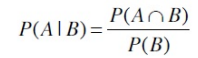

###  Bayes 貝葉斯法則 
貝葉斯法則描述了P(h)、P(h|D)、P(D)、以及P(D|h)這四個概率之間的關係：
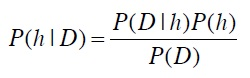


我們選取Tom M. Mitchell《機器學習》中的例子。這個例子是通過一次血液檢驗來判斷某人是否患有某種癌症。已知這種癌症在美國的感染率 是0.8%。血液檢驗的結果有陽性和陰性兩種，且存在準確性的問題：如果這個人患有癌症， 則有98%的機率測出陽性；如果他沒有癌症，會有97%的機率測出陰性。

我們來嘗試將這些描述語言用公式來表示： 
- 美國有 0.8% 的人患有這種癌症：P(癌症) = 0.008 
- 美國有99.2% 的人沒有患有癌症：P(┐癌症)  = 0.992 
- 患有癌症返回陽性的概率是 98%：P(陽性|癌症)  = 0.98 
- 患有癌症返回陰性的概率是  2%：P(陰性|癌症)  = 0.02 
- 沒有癌症返回陰性的概率是 97%：P(陰性|┐癌症) = 0.97 
- 沒有癌症返回陽性的概率是  3%：P(陽性|┐癌症) = 0.03

Ann到醫院做了血液檢測呈陽性。初看結果並不樂觀，畢竟血液檢測準確率高達 98%。

- 用貝葉斯法則來計算看看： 
- P(陽性|癌症)P(癌症) = 0.98 * 0.008 = 0.0078 
- P(陽性|┐癌症)P(┐癌症) = 0.03 * 0.992 = 0.0298
- P(癌症|陽性) = 0.0078 / (0.0078+0.298) = 0.21
- 得知在可以看到，血液檢測為陽性的人患有這種癌症的概率是 21%。

可能你會覺得這並不合理，畢竟血液檢測的準確率有98%，而結果卻說 Ann 很可能並沒有這種癌症。很多人只看到了血液檢測的準確率是98%，但沒有考慮到全美只有0.8%的人患有這種癌症。假設我們給一個有著一百萬人口的城市做血液檢測

- 1,000,000 人口
- 8,000 人患有癌症 (有7,840個人的結果呈陽性,160人呈陰性)
- 992,000 人沒有癌症 (有962,240人會呈陰性，30,000人呈陽性)
- 總結到下表中：Ann的測試結果呈陽性，從表看陽性有30,000人其實是健康的，只有7,840人確實患有癌症，所以我們才會認為Ann很有可能是健康的。

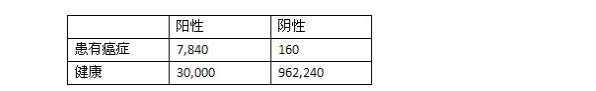

In [7]:
class Classifier:
    def __init__(self, bucketPrefix, testBucketNumber, dataFormat):
        total = 0
        classes = {}
        counts = {}
        
        # reading the data in from the file
        self.format = dataFormat.strip().split('\t')
        self.prior = {}
        self.conditional = {}
        
        # for each of the buckets numbered 1 through 10:
        for i in range(1, 11):
            
            # if it is not the bucket we should ignore, read in the data
            if i != testBucketNumber:
                filename = "%s-%02i" % (bucketPrefix, i)
                f = open(filename)
                lines = f.readlines()
                f.close()
                for line in lines:
                    fields = line.strip().split('\t')
                    ignore = []
                    vector = []
                    for i in range(len(fields)):
                        if self.format[i] == 'num':
                            vector.append(float(fields[i]))
                        elif self.format[i] == 'attr':
                            vector.append(fields[i])                           
                        elif self.format[i] == 'comment':
                            ignore.append(fields[i])
                        elif self.format[i] == 'class':
                            category = fields[i]
                    # now process this instance
                    total += 1
                    classes.setdefault(category, 0)
                    counts.setdefault(category, {})
                    classes[category] += 1
                    # now process each attribute of the instance
                    col = 0
                    for columnValue in vector:
                        col += 1
                        counts[category].setdefault(col, {})
                        counts[category][col].setdefault(columnValue, 0)
                        counts[category][col][columnValue] += 1
        
        for (category, count) in classes.items():
            self.prior[category] = count / total

        # now compute conditional probabilities p(D|h)
        for (category, columns) in counts.items():
            self.conditional.setdefault(category, {})
            for (col, valueCounts) in columns.items():
                self.conditional[category].setdefault(col, {})
                for (attrValue, count) in valueCounts.items():
                    self.conditional[category][col][attrValue] = (count / classes[category])
        self.tmp =  counts               
        
        
    def testBucket(self, bucketPrefix, bucketNumber):
        filename = "%s-%02i" % (bucketPrefix, bucketNumber)
        f = open(filename)
        lines = f.readlines()
        totals = {}
        f.close()
        loc = 1
        for line in lines:
            loc += 1
            data = line.strip().split('\t')
            vector = []
            classInColumn = -1
            for i in range(len(self.format)):
                if self.format[i] == 'num':
                    vector.append(float(data[i]))
                elif self.format[i] == 'attr':
                    vector.append(data[i])
                elif self.format[i] == 'class':
                    classInColumn = i
            theRealClass = data[classInColumn]
            classifiedAs = self.classify(vector)
            totals.setdefault(theRealClass, {})
            totals[theRealClass].setdefault(classifiedAs, 0)
            totals[theRealClass][classifiedAs] += 1
        return totals


    
    def classify(self, itemVector):
        """Return class we think item Vector is in"""
        results = []
        for (category, prior) in self.prior.items():
            prob = prior
            col = 1
            for attrValue in itemVector:
                if not attrValue in self.conditional[category][col]:
                    # we did not find any instances of this attribute value
                    # occurring with this category so prob = 0
                    prob = 0
                else:
                    prob = prob * self.conditional[category][col][attrValue]
                col += 1
            results.append((prob, category))
        # return the category with the highest probability
        return(max(results)[1])


def tenfold(bucketPrefix, dataFormat):
    results = {}
    for i in range(1, 11):
        c = Classifier(bucketPrefix, i, dataFormat)
        t = c.testBucket(bucketPrefix, i)
        for (key, value) in t.items():
            results.setdefault(key, {})
            for (ckey, cvalue) in value.items():
                results[key].setdefault(ckey, 0)
                results[key][ckey] += cvalue
                
    # now print results
    categories = list(results.keys())
    categories.sort()
    print(   "\n            Classified as: ")
    header =    "             "
    subheader = "               +"
    for category in categories:
        header += "% 10s   " % category
        subheader += "-------+"
    print (header)
    print (subheader)
    total = 0.0
    correct = 0.0
    for category in categories:
        row = " %10s    |" % category 
        for c2 in categories:
            if c2 in results[category]:
                count = results[category][c2]
            else:
                count = 0
            row += " %5i |" % count
            total += count
            if c2 == category:
                correct += count
        print(row)
    print(subheader)
    print("\n%5.3f percent correct" %((correct * 100) / total))
    print("total of %i instances" % total)

tenfold("input/house-votes/hv", 
        "class\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tattr")
c = Classifier("input/house-votes/hv", 0,"class\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tattr")


            Classified as: 
               democrat   republican   
               +-------+-------+
   democrat    |   111 |    13 |
 republican    |     9 |    99 |
               +-------+-------+

90.517 percent correct
total of 232 instances


In [8]:
c = Classifier("input/iHealth/i", 10,
               "attr\tattr\tattr\tattr\tclass")
print(c.classify(['health', 'moderate', 'moderate', 'yes']))

i500


In [10]:
c = Classifier("input/house-votes/hv", 5, 
               "class\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tattr\tattr")
t = c.testBucket("input/house-votes/hv", 5)
print(t)

{'democrat': {'democrat': 12}, 'republican': {'republican': 10, 'democrat': 1}}


你可能聽說過正態分佈、鐘型曲線、高斯分佈等術語，他們指的是同一件事：68%的數據會 落在標準差為1的範圍內，95%的數據會落在標準差為2的範圍內：在我們的示例中，平均值是106.111，樣本標準差是21.327，因此購買i500的用戶中有95%的 人收入在42,660美元至149,770美元之間。如果我問你P(100k|i500)的概率有多大，你可以回 答非常大；如果問你P(20k|i500)的概率有多大，你可以回答基本不可能。

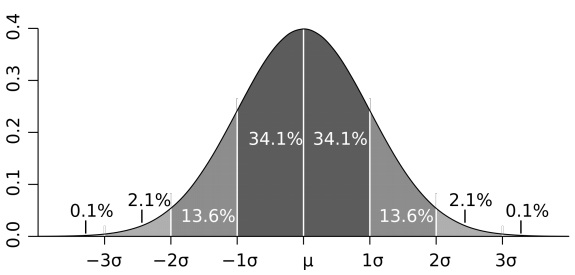